In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

### Data pre-processing

Only alter the data pre-processing code if you have completed the challenge for that section.

In [2]:
# The data URI
csv_file_uri = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "target"
]


data_original = pd.read_csv(csv_file_uri, names=column_names, index_col=False)

USE_LABEL_ENCODER = False


if USE_LABEL_ENCODER:

    # Make a copy so that we always have the original data to refer to
    data = data_original.copy(deep=True)

    # Drop the US weights (don't have any value)
    data.drop(["fnlwgt"], axis=1, inplace=True)

    # Create a function that changes the text to a simple binary value
    def convert_target_variable(text):
        if text == " <=50K":
            return 0
        else:
            return 1

    data["target"] = data.target.apply(convert_target_variable)

    encoded_columns = []
    for c in data.columns:
        if data[c].dtype == "object":
            if "{}_encoded".format(c) not in data.columns:
                encoder = preprocessing.LabelEncoder()
                data["{}_encoded".format(c)] = encoder.fit_transform(data[c].values)
                encoded_columns.append(c)
                encoder = None
            else:
                print("{}_encoded already exists".format(c))

    print("Dropping the encoded columns {}".format(encoded_columns))
    data.drop(encoded_columns, axis=1, inplace=True)
    
else:
    
    # Make a copy so that we always have the original data to refer to
    data_pre_dummies = data_original.copy(deep=True)

    # Drop the US weights (don't have any value)
    data_pre_dummies.drop(["fnlwgt"], axis=1, inplace=True)
    
    data = pd.get_dummies(data_pre_dummies)

    # Deletes the original column in this dataframe.
    data.drop(["target_ <=50K"], axis=1, inplace=True)

    # Rename the target
    data.rename(columns={'target_ >50K': 'target' }, inplace=True)

In [3]:
feature_columns = data.columns.tolist()
feature_columns.remove("target")

---
### Model: Decision Tree

Scikit-learn [docs](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In [4]:
from sklearn import tree

In [5]:
clf = tree.DecisionTreeClassifier(max_depth=5)

In [6]:
X = data[feature_columns].values
y = data.target.values

In [7]:
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [8]:
print("The accuracy is {:6.2f}%".format(clf.score(X,y)*100.0))

The accuracy is  85.20%


In [9]:
# How did the model do this? We can see the importance 
# for each column using 
# print(clf.feature_importances_)

# Pretty print with the column names
for ix, c in enumerate(feature_columns):
    if clf.feature_importances_[ix] > 0.0:
        print("Column {} is {}".format(c, clf.feature_importances_[ix]))

Column age is 0.011755059371818876
Column education-num is 0.23449266282782444
Column capital-gain is 0.21847301246417028
Column capital-loss is 0.04694665854355955
Column hours-per-week is 0.02198946883889202
Column workclass_ Self-emp-not-inc is 0.00029643698326237204
Column education_ Preschool is 0.00039439379302728744
Column marital-status_ Married-civ-spouse is 0.4652860762776799
Column occupation_ Farming-fishing is 7.730273208518886e-05
Column occupation_ Protective-serv is 0.0002889281676801234


---
### Visualize the Tree

In [10]:
# Install dependency
!apt install graphviz

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk1.8.0_144.jdk/Contents/Home/bin/apt" (-1)


In [11]:
# Install dependency
!pip install graphviz

In [12]:
import graphviz

tree.export_graphviz(clf, out_file="/tmp/tree.dot")
with open("/tmp/tree.dot") as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

---
### Challenge: Add Cross Validation

In [13]:
# Add cross-validation to a deep (max_depth) Decision Tree and see
# how the training and testing accuracy will diverge.
# Why is this?

In [14]:
# Create a training and a testing group.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Train the model on the training set
clf = None
clf = tree.DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)

# Predict on the train, test set and compare the results
accuracy_train = clf.score(X_train, y_train)
accuracy_test = clf.score(X_test, y_test)
print("- This model training accuracy of {}".format(accuracy_train))
print("- This model testing accuracy of {}".format(accuracy_test))
print("- The ratio is {}".format(accuracy_test/accuracy_train))

- This model training accuracy of 0.8442874692874693
- This model testing accuracy of 0.8509571092230526
- The ratio is 1.0078997263114802


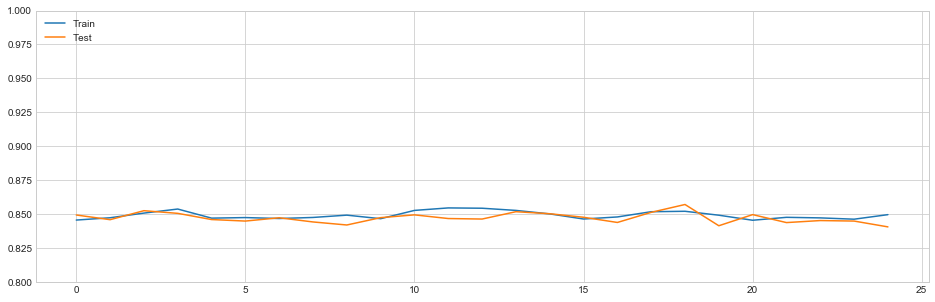

In [15]:
accuracies_train = []
accuracies_test = []

# Cross validation in a loop.
for i in range(25):
    
    # Create a training and a testing group.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    # Train the model on the training set
    clf = None
    clf = tree.DecisionTreeClassifier(max_depth=5)
    clf.fit(X_train, y_train)

    # Predict on the train, test set and compare the results
    accuracies_train.append(clf.score(X_train, y_train))
    accuracies_test.append(clf.score(X_test, y_test))

assert len(accuracies_train) == len(accuracies_test)
plt.figure(figsize=(16,5))
plt.plot(range(len(accuracies_train)), accuracies_train, label='Train')
plt.plot(range(len(accuracies_test)), accuracies_test, label='Test')
plt.ylim(0.8,1.0)
plt.legend(loc='upper left')

---
### Challenge: Implement a Random Forest

See notes [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html#Ensembles-of-Estimators:-Random-Forests)

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
# Create a training and a testing group.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Train the model on the training set
clf = None
clf = RandomForestClassifier(n_estimators=100, max_depth=5)
clf.fit(X_train, y_train)

# Predict on the train, test set and compare the results
accuracy_train = clf.score(X_train, y_train)
accuracy_test = clf.score(X_test, y_test)
print("- This model training accuracy of {}".format(accuracy_train))
print("- This model testing accuracy of {}".format(accuracy_test))
print("- The ratio is {}".format(accuracy_test/accuracy_train))

- This model training accuracy of 0.8427079677079677
- This model testing accuracy of 0.8346811342000204
- The ratio is 0.9904749523968795


---
### Challenges: Test different Hyper-parameters for a Random Forest

In [18]:
# Change some of the hyper-parameters and
# see how it impacts the tree and performance
# Hyper-parameters:
# - max_depth
# - n_estimators

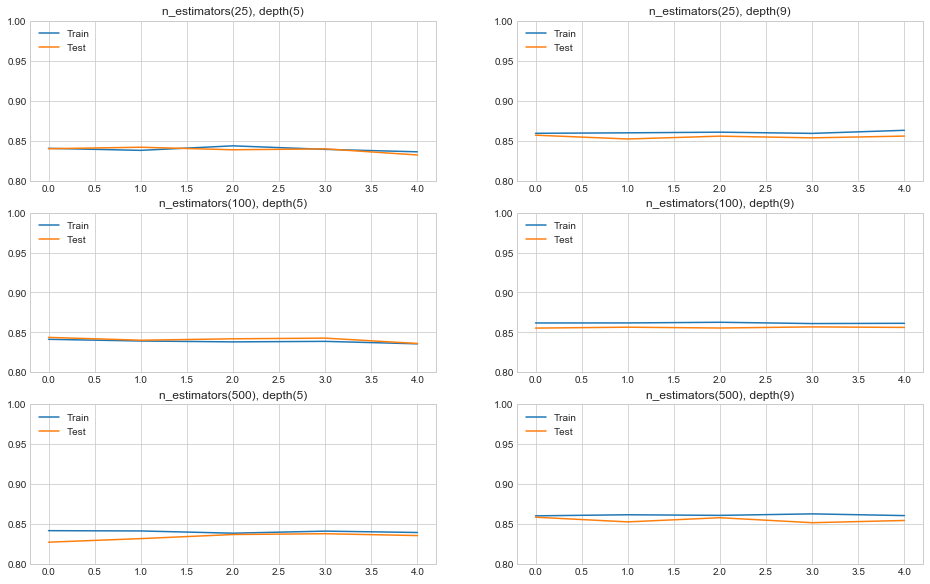

In [19]:
plt.figure(figsize=(16,10))

n_estimators = [25,100,500]
max_depths = [5, 9]

ctr = 1
for ix,n_param in enumerate(n_estimators):
    for jx,depth in enumerate(max_depths):
        
        accuracies_train = []
        accuracies_test = []
        
        # Cross validation in a loop.
        for i in range(5):

            # Create a training and a testing group.
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

            # Train the model on the training set
            clf = None
            clf = RandomForestClassifier(n_estimators=n_param, max_depth=depth)
            clf.fit(X_train, y_train)

            # Predict on the train, test set and compare the results
            accuracies_train.append(clf.score(X_train, y_train))
            accuracies_test.append(clf.score(X_test, y_test))
            
        plt.subplot(len(n_estimators),len(max_depths), ctr)
        ctr += 1
        assert len(accuracies_train) == len(accuracies_test)
        plt.plot(range(len(accuracies_train)), accuracies_train, label='Train')
        plt.plot(range(len(accuracies_test)), accuracies_test, label='Test')
        plt.ylim(0.8,1.0)
        plt.legend(loc='upper left')
        plt.title("n_estimators({}), depth({})".format(n_param, depth))

---
### Challenges: Cross-validation for a Random Forest

In [ ]:
# Implement cross-validation

In [ ]:
accuracies_train = []
accuracies_test = []

# Cross validation in a loop.
for i in range(5):
    
    # Create a training and a testing group.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    # Train the model on the training set
    clf = None
    clf = RandomForestClassifier(n_estimators=100, max_depth=5)
    clf.fit(X_train, y_train)

    # Predict on the train, test set and compare the results
    accuracies_train.append(clf.score(X_train, y_train))
    accuracies_test.append(clf.score(X_test, y_test))

assert len(accuracies_train) == len(accuracies_test)
plt.figure(figsize=(16,5))
plt.plot(range(len(accuracies_train)), accuracies_train, label='Train')
plt.plot(range(len(accuracies_test)), accuracies_test, label='Test')
plt.ylim(0.8,1.0)
plt.legend(loc='upper left')

---
### More reading

* [BUILDING DECISION TREE ALGORITHM IN PYTHON WITH SCIKIT LEARN](http://dataaspirant.com/2017/02/01/decision-tree-algorithm-python-with-scikit-learn/)
* [
How To Implement The Decision Tree Algorithm From Scratch In Python](https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/)